# Timeseries classification from scratch

This example shows how to do timeseries classification from scratch, starting from raw CSV 
timeseries files on disk. We demonstrate the workflow on the FordA dataset from the [UCR/UEA 
archive](https://www.cs.ucr.edu/~eamonn/time_series_data_2018/).

In [8]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA. The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances. 
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor. 
For this task, the goal is to automatically detect the presence of a specific issue with 
the engine. The problem is a balanced binary classification task. The full description 
of this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the FordA_TRAIN file for training and the FordA_TEST file for testing. The simplicity of this dataset allows us to demonstrate effectively how to use ConvNets for timeseries classification. In this file, the first column corresponds to the label.

In [19]:
def read_ucr_dataset(filename):
    root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"
    data = np.loadtxt(root_url + filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

x_train, y_train = read_ucr_dataset("FordA_TRAIN.tsv")
x_test, y_test = read_ucr_dataset("FordA_TEST.tsv")

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

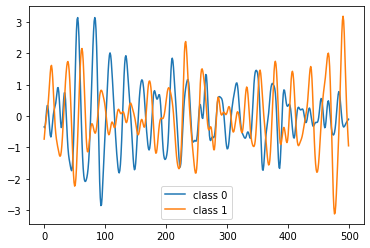

In [9]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))

plt.legend(loc="best")
plt.show()
plt.close()


## Standardize the data

Our timeseries are already in a single length (500). However, their values are usually in various ranges. This is not ideal for a neural network; in general we should seek to make the input values normalized. For this specific dataset, the data is already z-normalized: each timeseries sample has a mean equal to zero and a standard deviation equal to one. This type of normalization is very common for timeseries classification problems, see Bagnall et al. (2016).

In [16]:
# Note that the timeseries data used here are univariate, meaning we only have one channel 
# per timeseries example. We will therefore transform the timeseries into a multivariate 
# one with one channel using a simple reshaping via numpy. This will allow us to construct 
# a model that is easily applicable to multivariate time series.
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Finally, in order to use `sparse_categorical_crossentropy`, we will have to count the 
# number of classes beforehand.
num_classes = len(np.unique(y_train))

# Now we shuffle the training set because we will be using the validation_split option 
# later when training.
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

# Standardize the labels to positive integers. The expected labels will then be 0 and 1.
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0


## Build a model

We build a Fully Convolutional Neural Network originally proposed in this [paper](https://arxiv.org/abs/1611.06455). 
The implementation is based on the TF 2 version provided [here](https://github.com/hfawaz/dl-4-tsc/). 
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found via 
random search using [KerasTuner](https://github.com/keras-team/keras-tuner).


In [18]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
